### Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

### Read in data

In [2]:
athletes = pd.read_csv("athletes.csv")
athletes.head()

,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,...,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,...,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,...,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,...,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,...,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|


In [3]:
# Get the relevant columns only
athletes_clean = athletes.loc[:, ["gender", "age", "height", "weight", "run5k", "deadlift", "eat", "train", "background", "experience", "schedule", "howlong"]].copy()

### Clean data

In [4]:
athletes_clean.describe()

,age,height,weight,run5k,deadlift
count,331110.000000,1.598690e+05,229890.000000,3.609700e+04,1.153230e+05
mean,32.516750,1.206217e+02,170.896137,3.411464e+03,6.970503e+02
std,7.730671,2.097995e+04,58.379799,1.251980e+05,5.523235e+04
min,13.000000,0.000000e+00,1.000000,1.000000e+00,-5.000000e+02
25%,27.000000,6.600000e+01,145.000000,1.242000e+03,2.550000e+02
50%,31.000000,6.900000e+01,170.000000,1.380000e+03,3.450000e+02
75%,37.000000,7.200000e+01,192.000000,1.560000e+03,4.150000e+02
max,125.000000,8.388607e+06,20175.000000,8.388607e+06,8.388607e+06


Definitely some outliers in here. We will have to figure out what to do with those.

In [5]:
athletes.isna().sum()

athlete_id         3
name           91896
region        171744
team          267846
affiliate     181090
gender         91896
age            91896
height        263137
weight        193116
fran          367580
helen         392727
grace         382261
filthy50      403647
fgonebad      393268
run400        400760
run5k         386909
candj         318571
snatch        325726
deadlift      307683
backsq        312489
pullups       372398
eat           329074
train         317175
background    324061
experience    318070
schedule      325131
howlong       313800
dtype: int64

PLENTY of missing values here. Our dataset will be considerably smaller by the time we actually go to model. 

c:\Users\brown\miniconda3\envs\DSenv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


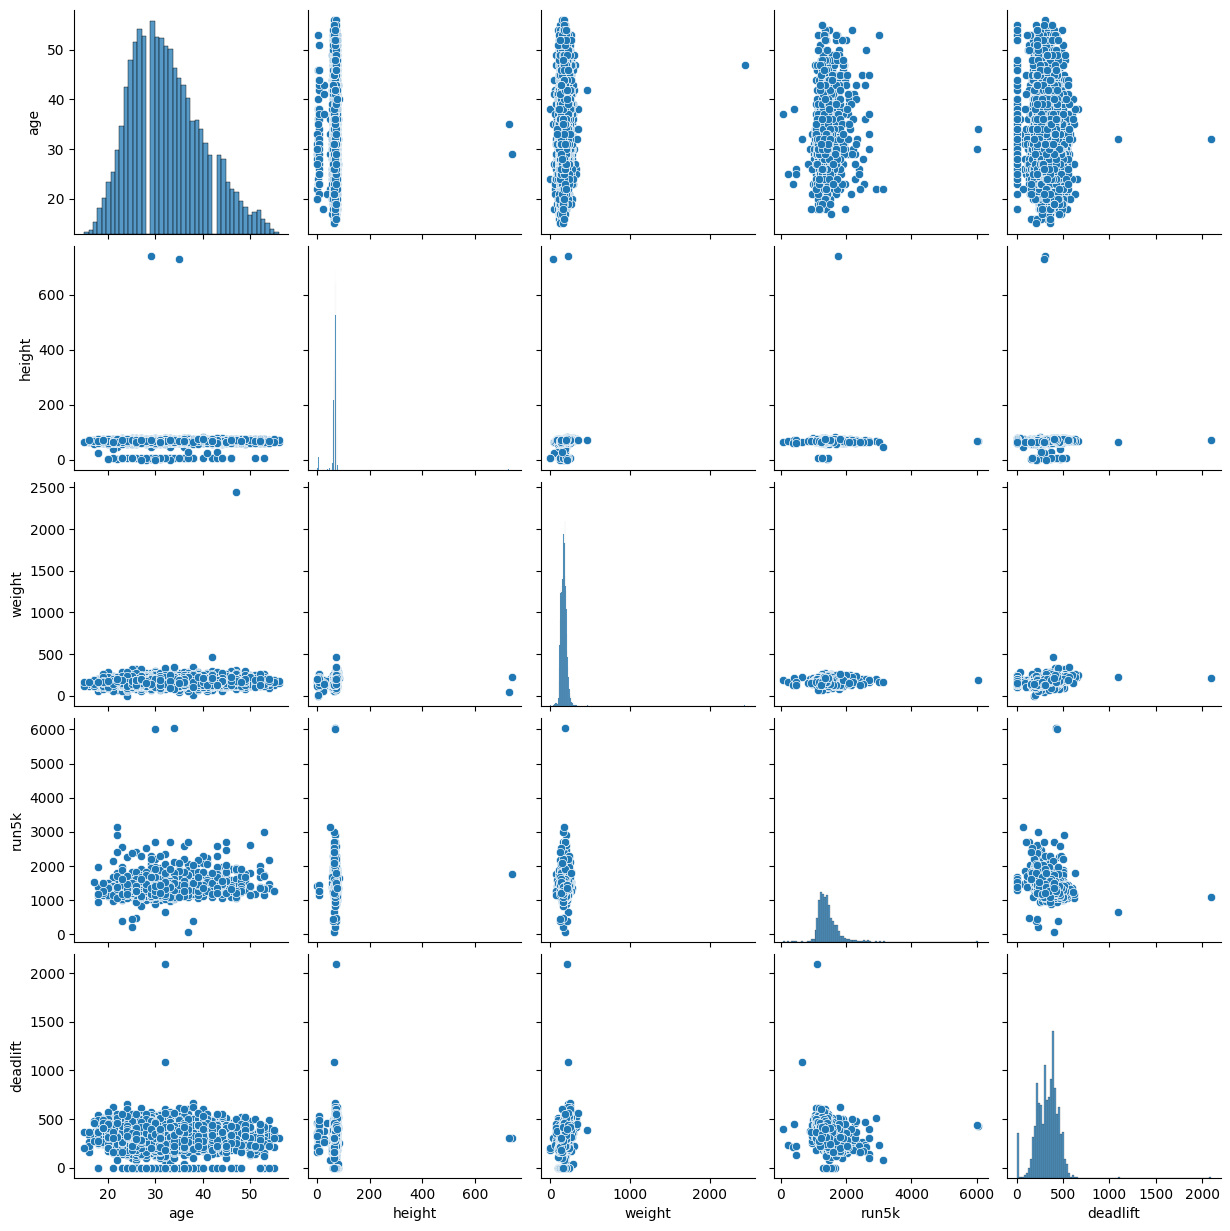

In [6]:
athletes_sampled = athletes_clean.sample(n = 12000, random_state = 31958)
sns.pairplot(athletes_sampled);

Despite some outliers and some wierd looking gaps in age, this looks pretty normally distributed and solid overall. 

In [7]:
# Start by removing weird values from the above plot. 
athletes_clean = athletes_clean.query('weight >= 100 and weight <= 320 and \
                                      height >= 54 and height <= 85 and \
                                      age <= 85 and \
                                      run5k >= 755 and run5k <= 2700 and \
                                      deadlift >= 45 and deadlift <= 1185')

c:\Users\brown\miniconda3\envs\DSenv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


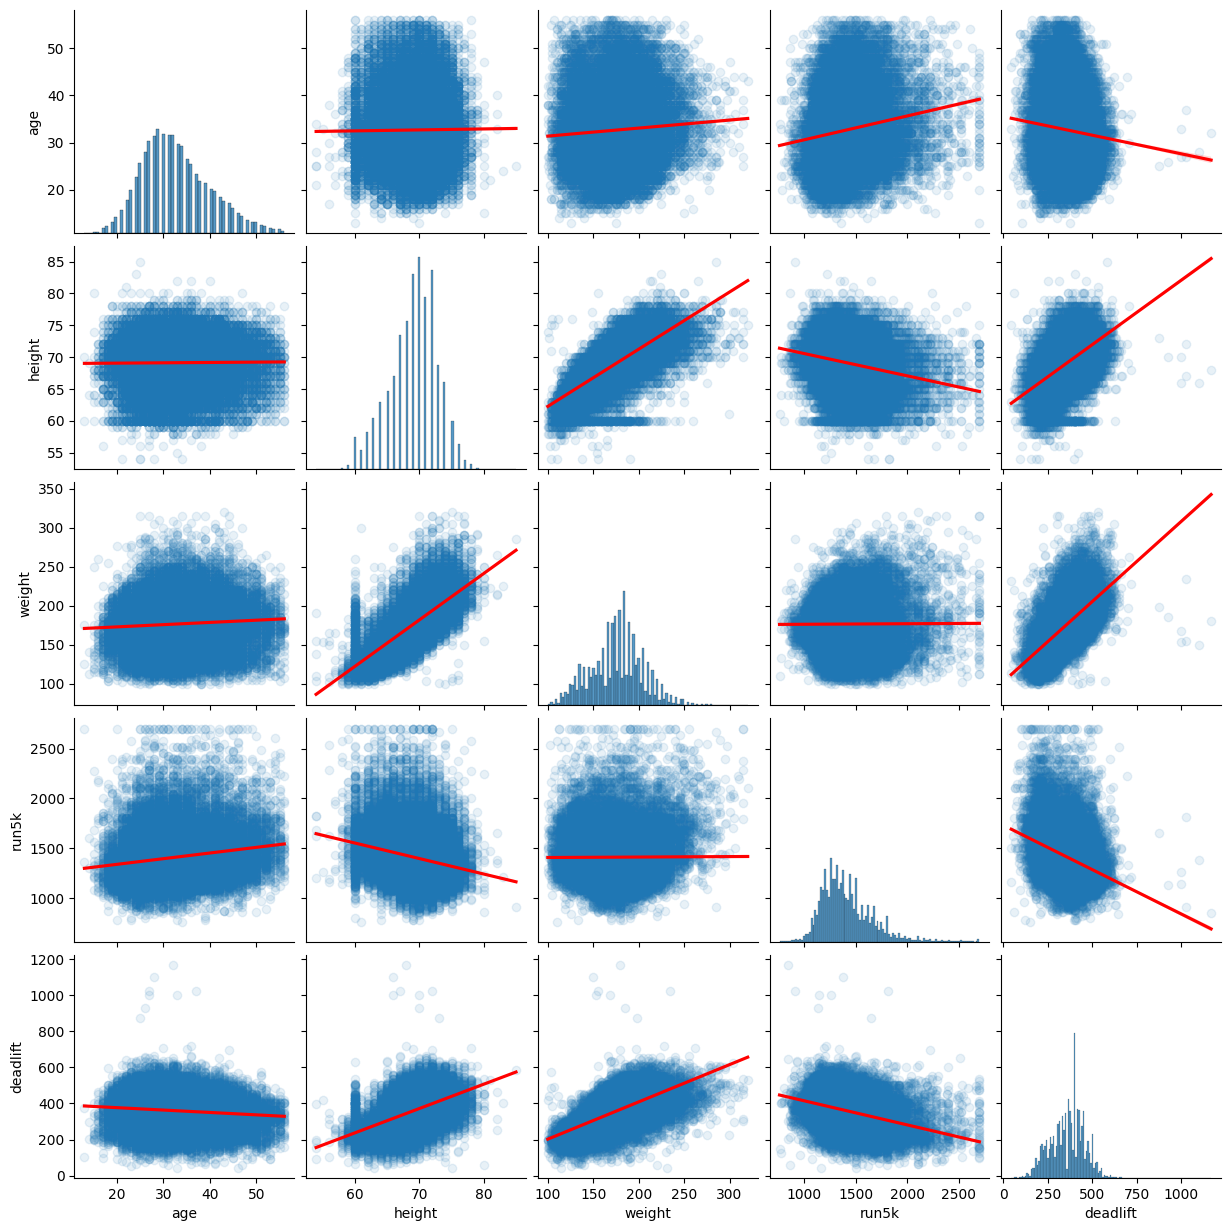

In [8]:
sns.pairplot(athletes_clean, kind = 'reg', plot_kws = {'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.1}});

Some relationships look considerably less significant now, but let's continue on to the non-numeric data. 
<br>
<br>
Much of the categorical data has multiple answer selected per athlete, so we will need to find a way around this. 

In [9]:
athletes_clean.head()

,gender,age,height,weight,run5k,deadlift,eat,train,background,experience,schedule,howlong
9,Male,40.0,68.0,177.0,1361.0,365.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I rec...,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I typically ...,2-4 years|
12,Male,31.0,65.0,150.0,1211.0,465.0,I eat quality foods but don't measure the amou...,I workout mostly at a CrossFit Affiliate|I wri...,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 3+ times a week|,2-4 years|
18,Male,30.0,70.0,155.0,1140.0,335.0,NaN,NaN,NaN,NaN,NaN,NaN
20,Male,42.0,72.0,210.0,1412.0,515.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I wri...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,NaN,4+ years|
21,Male,30.0,71.0,200.0,1584.0,385.0,I eat whatever is convenient|,I workout mostly at a CrossFit Affiliate|I inc...,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 1x a week|I ty...,1-2 years|


##### Gender

In [10]:
dummy_gender = pd.get_dummies(athletes_clean['gender']).drop('--', axis = 1)
athletes_clean = pd.concat([athletes_clean, dummy_gender], axis = 1)

##### Eating habits

In [11]:
# Drop rows with NaN in 'eat' column
athletes_clean = athletes_clean.dropna(subset = ['eat'])

# Split the values in the 'eat' column by "|" and create dummy variables
dummy_eats = pd.get_dummies(athletes_clean['eat'].str.split('|', expand = True).stack(), prefix = 'eat').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_eats = dummy_eats.drop(columns = 'eat_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_eats], axis=1)

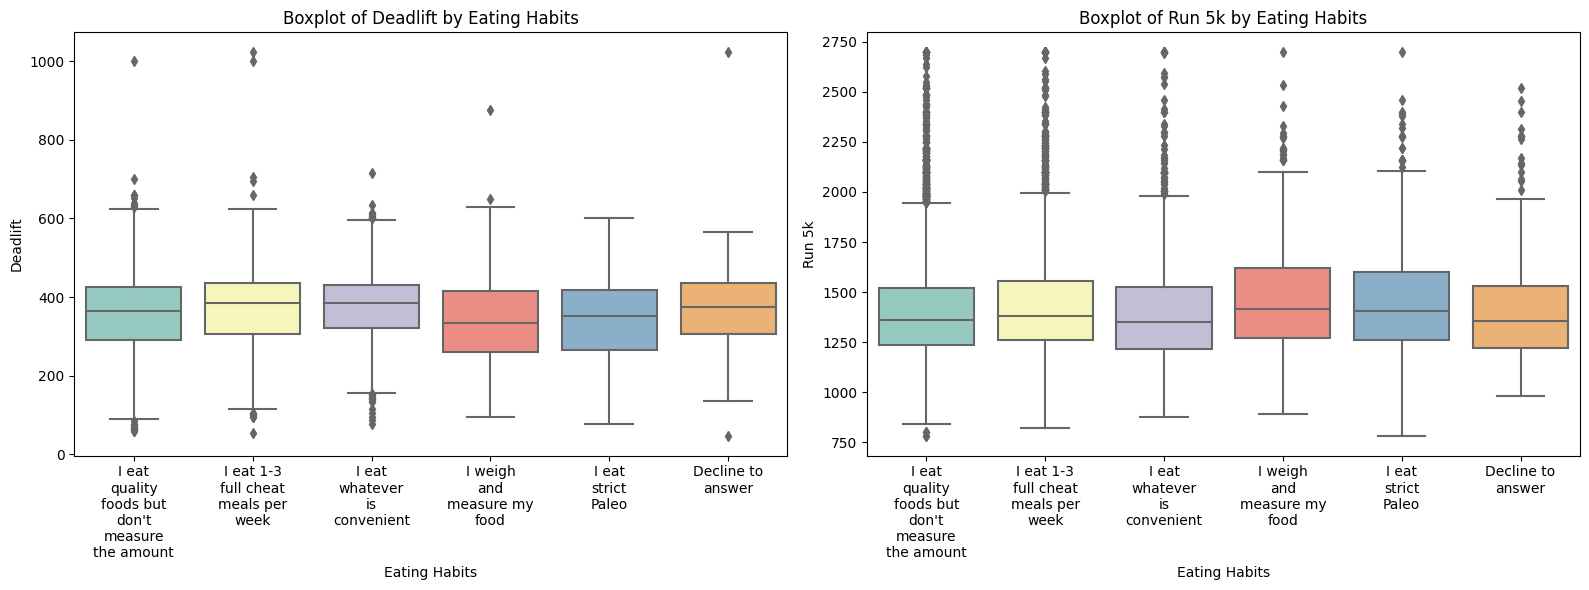

In [12]:
import textwrap

# Create a new column 'eating_habits' combining all eating habits for each athlete
athletes_clean['eating_habits'] = athletes_clean.filter(like='eat_').idxmax(axis=1).str.replace('eat_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['eating_habits'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[0], x='eating_habits', y='deadlift', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Eating Habits')
axes[0].set_xlabel('Eating Habits')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='eating_habits', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Eating Habits')
axes[1].set_xlabel('Eating Habits')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

It doesn't look like the groups are that different, although they do overlap some anyway, which may provide some of the reason for that. 

##### Training

In [13]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset=['train'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_train = pd.get_dummies(athletes_clean['train'].str.split('|', expand = True).stack(), prefix = 'train').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_train = dummy_train.drop(columns = 'train_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_train], axis=1)

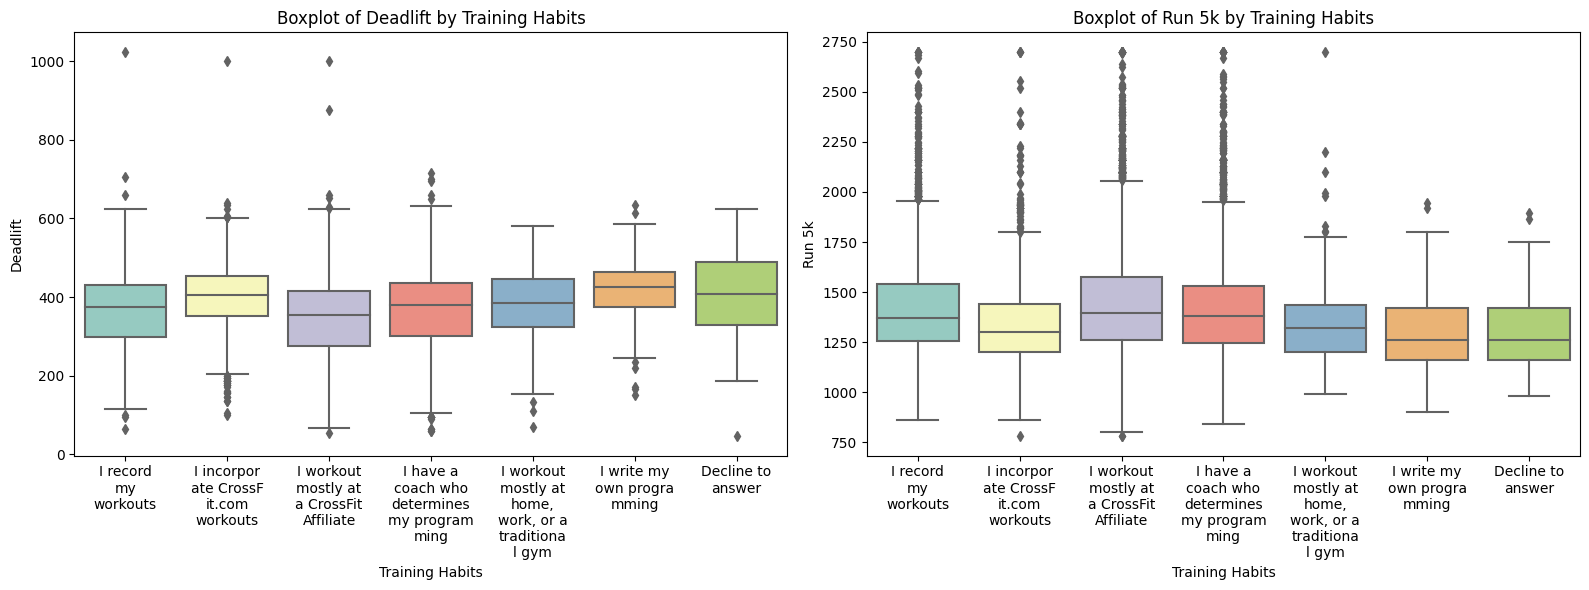

In [14]:
# Create a new column 'training_habits' combining all training habits for each athlete
athletes_clean['training_habits'] = athletes_clean.filter(like = 'train_').idxmax(axis=1).str.replace('train_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['training_habits'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[0], x='training_habits', y='deadlift', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Training Habits')
axes[0].set_xlabel('Training Habits')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='training_habits', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Training Habits')
axes[1].set_xlabel('Training Habits')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### Athletic background

In [15]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['background'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_background = pd.get_dummies(athletes_clean['background'].str.split('|', expand = True).stack(), prefix = 'background').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_background = dummy_background.drop(columns = 'background_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_background], axis = 1)

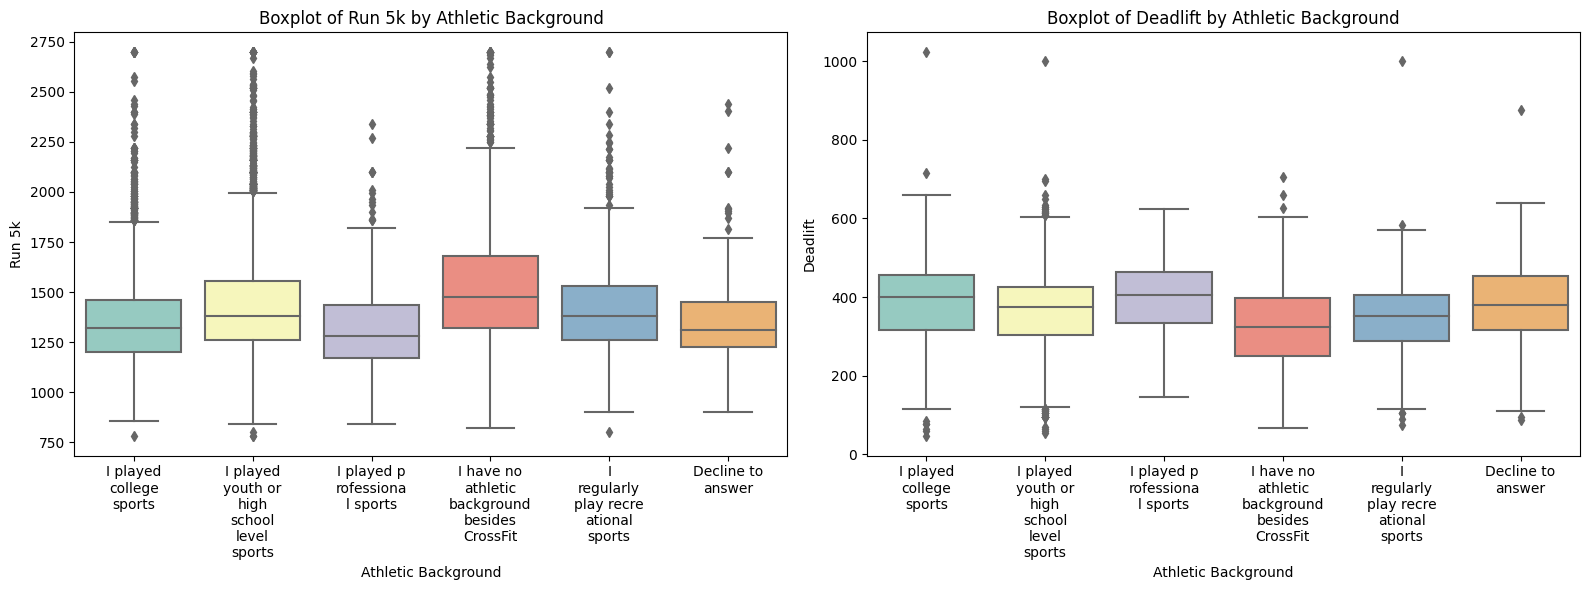

In [16]:
# Create a new column 'training_habits' combining all training habits for each athlete
athletes_clean['athletic_bg'] = athletes_clean.filter(like = 'background_').idxmax(axis=1).str.replace('background_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['athletic_bg'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[0], x='athletic_bg', y='run5k', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Run 5k by Athletic Background')
axes[0].set_xlabel('Athletic Background')
axes[0].set_ylabel('Run 5k')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[1], x='athletic_bg', y='deadlift', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Deadlift by Athletic Background')
axes[1].set_xlabel('Athletic Background')
axes[1].set_ylabel('Deadlift')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### Crossfit experience

In [17]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['experience'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_experience = pd.get_dummies(athletes_clean['experience'].str.split('|', expand = True).stack(), prefix = 'experience').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_experience = dummy_experience.drop(columns = 'experience_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_experience], axis = 1)

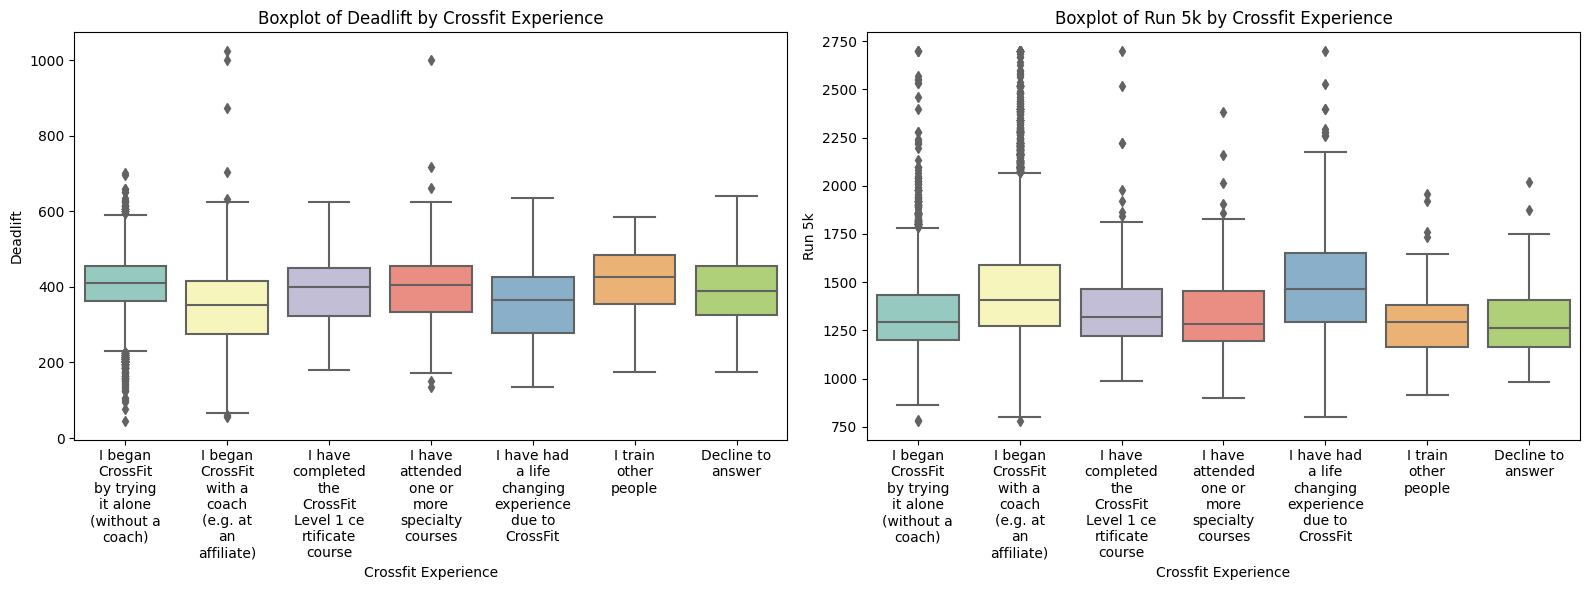

In [18]:
# Create a new column 'crossfit_experience' combining all training habits for each athlete
athletes_clean['crossfit_experience'] = athletes_clean.filter(like = 'experience_').idxmax(axis=1).str.replace('experience_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['crossfit_experience'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[0], x = 'crossfit_experience', y = 'deadlift', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Crossfit Experience')
axes[0].set_xlabel('Crossfit Experience')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='crossfit_experience', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Crossfit Experience')
axes[1].set_xlabel('Crossfit Experience')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### Training schedule

In [19]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['schedule'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_schedule = pd.get_dummies(athletes_clean['schedule'].str.split('|', expand = True).stack(), prefix = 'schedule').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_schedule = dummy_schedule.drop(columns = 'schedule_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_schedule], axis = 1)

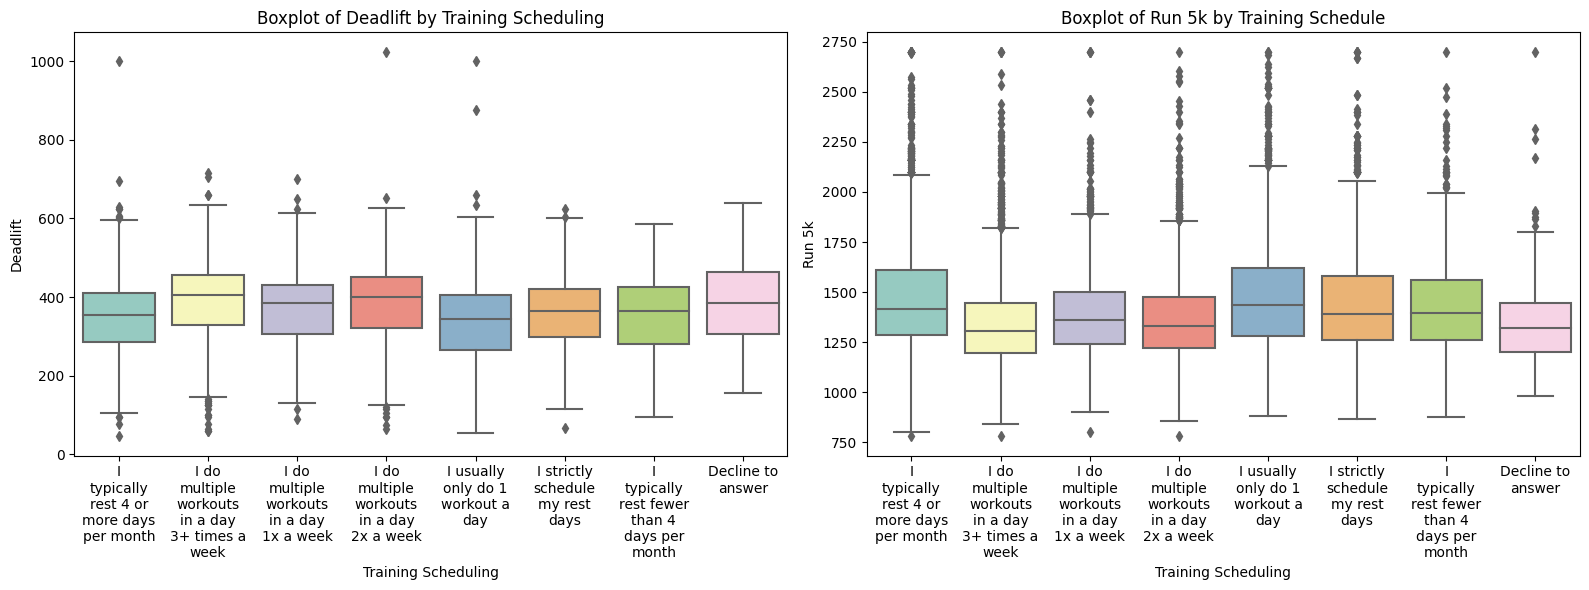

In [20]:
# Create a new column 'training_schedule' combining all training schedules for each athlete
athletes_clean['training_schedule'] = athletes_clean.filter(like = 'schedule_').idxmax(axis=1).str.replace('schedule_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['training_schedule'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax = axes[0], x = 'training_schedule', y = 'deadlift', data = athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Training Scheduling')
axes[0].set_xlabel('Training Scheduling')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='training_schedule', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Training Schedule')
axes[1].set_xlabel('Training Scheduling')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### How long have they been training

In [21]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['howlong'])

def find_longest_training(row):
    if pd.isna(row):
        return np.nan
    
    weights = {'Less than 6 months': 1, '6-12 months': 2, '1-2 years': 3, '2-4 years': 4, '4+ years': 5}
    
    categories = row.split('|')
    return max(categories, key = lambda x: weights.get(x, 0))

# Create a new column 'howlong_group' based on the longest category
athletes_clean['howlong_group'] = athletes_clean['howlong'].apply(find_longest_training)

# Split the values in the 'train' column by "|" and create dummy variables
dummy_howlong = pd.get_dummies(athletes_clean['howlong_group'].str.split('|', expand = True).stack(), prefix = 'howlong').groupby(level = 0).sum()

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_howlong], axis = 1)

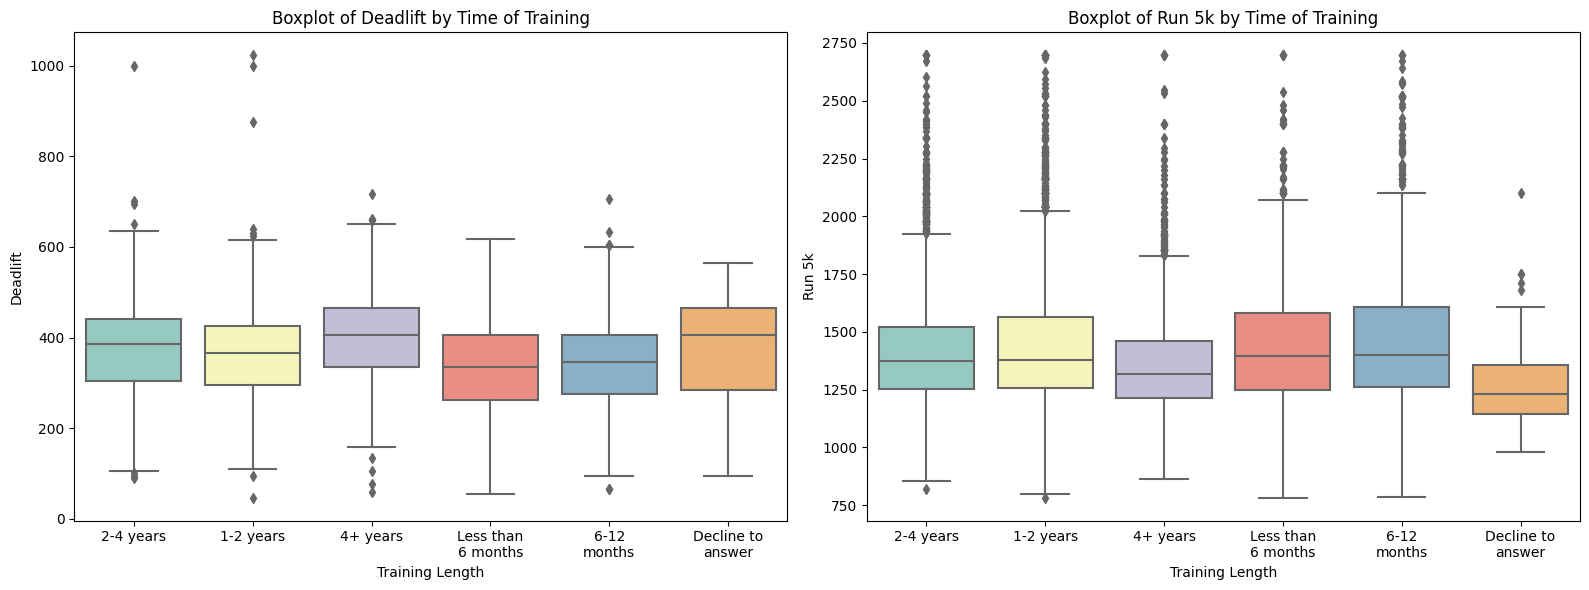

In [22]:
# Create a new column 'training_schedule' combining all training schedules for each athlete
athletes_clean['training_length'] = athletes_clean.filter(like = 'howlong_').drop('howlong_group', axis = 1).idxmax(axis=1).str.replace('howlong_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['training_length'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax = axes[0], x = 'training_length', y = 'deadlift', data = athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Time of Training')
axes[0].set_xlabel('Training Length')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='training_length', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Time of Training')
axes[1].set_xlabel('Training Length')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()